# [LEGALST-190] 4-19: Decision Trees and Ensemble Methods
---
<img src="https://c.pxhere.com/photos/df/5e/uganda_signs_outdoor_wooden_sign_direction_this_wy_that_way-341892.jpg!d" style="width: 600px; height: 400px;" />


This will wrap up the regression methods labs by introducing ensemble methods.

*Estimated Time: 40 minutes*

---

### Table of Contents


1 - [Base Model: Decision Trees](#section 1)<br>

2 - [Averaging Methods: Random Forest](#section 2)<br>

3 - [Boosting Methods: ADABoost](#section 3)<br>




**Dependencies:**

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import ipywidgets as widgets

## The Data: Bike Sharing<a id='section data'></a>

By now, you have been exposed to the bike sharing dataset several times. This lab's data describes one such bike sharing system in Washington D.C., from UC Irvine's Machine Learning Repository.

Information about the dataset: http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

In [2]:
bike = pd.read_csv('data/day.csv', index_col=0)
# reformat the date column to integers that represent the day of the year, 001-366
bike['dteday'] = pd.to_datetime(bike['dteday'].unique()).strftime('%j')

bike.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,001,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2,002,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
3,003,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
4,004,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
5,005,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## Introduction
Over the course of this class, we've seen that a single model may have significant trouble making accurate predictions. **Ensemble methods** seek to improve on the single-model method by combining the predictions from multiple base models.

This lab will cover the two types of ensemble methods- averaging and boosting- using decision trees as our base model. But, as you'll soon learn, one of the strengths of ensemble methods is their ability to solve many kinds of problems by leveraging many types of bases.

As always, we start by dividing our data into training, validation, and test data. 

In [3]:
X= bike.drop(['cnt', 'casual', 'registered'], axis=1)
y= bike.cnt

# set the random seed
np.random.seed(10)

# split the data with 0.20 proportion for test size
# train_test_split returns 4 values: X_train, X_test, y_train, y_test 
X, X_test, y, y_test = train_test_split(X, y,
                                            train_size=0.80, test_size=0.20)
# split the remaining data with 0.75 proportion for train size and 0.25 for validation size
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    train_size=0.75, test_size=0.25)

---
## 1. The Base Model: Decision Tree <a id='section 1'></a>

In the previous lab, you used an **ExtraTree** (EXTremely RAndomized TREE) to identify low-importance features. Extra trees are a subclass of a model called the **Decision Tree**, which we'll explore in more detail today.

Decision trees predict target values by creating a set of decision rules. The tree is made up of *nodes*, which constitute decision points, and *branches*, which represent the outcome of the decision. Here's an example using the popular Titanic data set to predict whether a passenger survived or not. Nodes are represented by the text, and branches by lines (left branch = 'yes', right branch='no').

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f3/CART_tree_titanic_survivors.png" style="width: 400px; height: 400px;" />

> *'sibsp' gives the number of siblings or spouses a passanger had on board. The left number under a leaf is the chance of survival for that subgroup; the right number is the percentage of passengers in that subgroup. *

Starting at the *root node* (which in computer science, somewhat counterintuitively, is at the top), the data is split into different subgroups at each decision node going top to bottom. The very bottom nodes in the tree (the *leaves*) assign prediction values to the data. 

**QUESTION:** Based on this decision tree, what would the model predict would happen to an 8-year-old boy with 2 sisters and a brother? What would the chance of survival be for a 28-year-old married man?

**ANSWER:** The boy would be predicted to survive. The man would have survived with a 17% chance.

While the Titanic data uses decision trees for categorization, they can also be used for regression. The process s very similar to the other Scikit-Learn models you've used.
1. Create the `DecisionTreeRegressor()` (use the default values for now)
2. Fit `X_train` and `y_train` to the regressor to create the model
3. Check the model's accuracy on the training and validation data using `.score`
4. Plot the predictions of the model against the actual values in a scatter plot

In [58]:
# make the DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(criterion='mse',  # how to measure fit
                                    splitter='best',  # or 'random' for random best split
                                    max_depth=None,  # how deep tree nodes can go
                                    min_samples_split=2,  # samples needed to split node
                                    min_samples_leaf=1,  # samples needed for a leaf
                                    min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                                    max_features=None,  # number of features to look for when splitting
                                    max_leaf_nodes=None,  # max nodes
                                    min_impurity_decrease=1e-07)  # early stopping

# fit the model
model = dt_reg.fit(X_train, y_train)

# score the model
print(model.score(X_train, y_train))
print(model.score(X_val, y_val))

1.0
0.8421168012114045


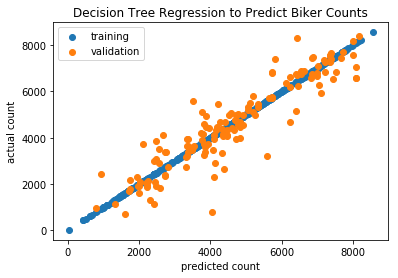

In [62]:
# predict the 
pred_y_val = model.predict(X_val)
pred_y_train = model.predict(X_train)
# plot the predicted values against the true values
plt.scatter(pred_y_train, y_train, label='training')
plt.scatter(pred_y_val, y_val, label='validation')
plt.xlabel('predicted count')
plt.ylabel('actual count')
plt.legend()
plt.title('Decision Tree Regression to Predict Biker Counts');

Like with most models, we can get better results by tuning the hyperparameters of the model.

The `max_depth=` parameter of DecisionTreeRegression constrains how many times a data set can be split. For example, the Titanic tree had a max depth of 3 (i.e. you could pass through at most 3 branches when going from the root to a leaf). 

`max_depth=` is set to `None` by default. Run the cell below, then use the slider to compare the predictions made using different max depths. 

In [55]:
def scatter_by_max_depth(depth):
    """Train a DecisionTreeRegressor with max_depth = DEPTH and
    plot the scatter plot of predicted values for training and validation data."""
    dt_reg = tree.DecisionTreeRegressor(max_depth = depth)
    model = dt_reg.fit(X_train, y_train)
    pred_y_val = model.predict(X_val)
    pred_y_train = model.predict(X_train)
    plt.scatter(pred_y_train, y_train, label='training')
    plt.scatter(pred_y_val, y_val, label='validation')
    plt.xlabel('predicted count')
    plt.ylabel('actual count')
    plt.title('Max depth = {}'.format(depth))
    print('training score: ', model.score(X_train, y_train))
    print('validation score: ', model.score(X_val, y_val))


slider = widgets.IntSlider(min=1, max=21,step=1,value=0)
display(widgets.interactive(scatter_by_max_depth, depth=slider))

interactive(children=(IntSlider(value=1, description='depth', max=21, min=1), Output()), _dom_classes=('widget-interact',))

**QUESTION:** How does training and validation accuracy change as the maximum depth changes? Why do the scatter plots look the way they do for small depths (aka shallow trees)? 

**ANSWER:** Training accuracy converges to 1 at about 21. Validation score maxes out at about 0.86 at a depth of 10, then hovers in the in the mid-eighties thereafter.

For a max depth of $n$, there are at most $2^n$ possible predicted values, since that's the maximum number of branch splits.  So, for low n, there will only be a few possible values, and all the predicted values will be concentrated in $2^n$ vertical bars.

## 2. Averaging Methods <a id='section 2'></a>

We have seen that the decision tree quickly maxed out its training set accuracy, but that accuracy didn't necessarily carry over to the validation set. We can try to address this overfitting issue using **averaging** ensemble methods. The intuition behind averaging is to build multiple estimators, then use the average of all their predictions as the final prediction.

### Random Forest

**Random Forest** accomplishes this by creating multiple decision trees (a 'forest' of them, if you will), each trained on sample of data drawn at random with replacement from the given set. Additionally, when each tree is constructed, not every feature is considered as a candidate on which to split the tree for each decision point.

By adding some randomization into the subsets and features that are considered by each model, then averaging the predictions across models, Random Forest can typically produce a model that is better at generalization.

**EXERCISE:** Create an out-of-the-box `RandomForestRegessor()` (i.e. use all the default settings), then fit it to the data and get the model's scores on the training and validation data. How does it compare to the Decision Tree?

In [68]:
# create the regressor
rf_reg = RandomForestRegressor(n_estimators=10,  # number of trees
                                        criterion='mse',  # how to measure fit
                                        max_depth=None,  # how deep tree nodes can go
                                        min_samples_split=2,  # samples needed to split node
                                        min_samples_leaf=1,  # samples needed for a leaf
                                        min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                                        max_features='auto',  # max feats
                                        max_leaf_nodes=None,  # max nodes
                                        n_jobs=1, # how many to run parallel
                                        random_state=10)
# fit the data 
model = rf_reg.fit(X_train, y_train)

#score the model on the training and validation data
print(model.score(X_train, y_train))
print(model.score(X_val, y_val))

0.9669808335267238
0.9043600518130036


### Grid Search

The process of choosing good hyperparameters can be tedious, involving a lot of trial and error. Fortunately, Scikit-Learn has a tool to help.

A **grid search** tests different possible parameter combinations to see which combination yields the best results. The grid is formatted as a dictionary, where the keys are the parameter names and the values are the different values you want to try for each parameter.

**EXERCISE:** Make a grid to use for a RandomForestRegressor.

In [77]:

param_grid = {'n_estimators': range(450, 551, 50),
              'max_depth': range(1, 12, 5),
              'min_samples_split': [2]}



Once the grid is made, it gets fed into a `GridSearchCV` along with the corresponding model. This may take several seconds to run- the computer is calculating the score for every possible combination of parameter values in the grid.

In [78]:
rf_reg2 = GridSearchCV(RandomForestRegressor(), param_grid)
rf_reg2.fit(X_train, y_train)


NameError: name 'fr_reg2' is not defined

Once we've fit the model to the data, information about the search process and results is stored in `.cv_results_`. Here's what you can see:

In [79]:
# the keys stored in the grid search process results dictionary
sorted(rf_reg2.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_max_depth',
 'param_min_samples_split',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

"params" contains the different combinations of parameters that were tried. "mean_test_score" gives the average score for models using each set of parameters. Items are matched by index- the ith score is for the ith set of parameters.

In [87]:
rf_reg2.cv_results_["params"]

[{'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 450},
 {'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 500},
 {'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 550},
 {'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 450},
 {'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 500},
 {'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 550},
 {'max_depth': 11, 'min_samples_split': 2, 'n_estimators': 450},
 {'max_depth': 11, 'min_samples_split': 2, 'n_estimators': 500},
 {'max_depth': 11, 'min_samples_split': 2, 'n_estimators': 550}]

In [88]:
rf_reg2.cv_results_["mean_test_score"]

array([0.47054664, 0.46986624, 0.47608035, 0.84602422, 0.84378396,
       0.843623  , 0.85553454, 0.85448989, 0.85757631])

**EXERCISE:** Find the set of parameters that got the best average score (`np.argmax` might help). Create a new random forest regressor using those parameters, then fit the model and print the scores for the training and validation data.

In [89]:
best_index = np.argmax(rf_reg2.cv_results_["mean_test_score"])
best_params = rf_reg2.cv_results_["params"][best_index]

# create the regressor
rf_reg = RandomForestRegressor(n_estimators=450,  # number of trees
                                        max_depth=11,  # how deep tree nodes can go
                                        min_samples_split=2)
# fit the data 
model = rf_reg.fit(X_train, y_train)

#score the model on the training and validation data
print(model.score(X_train, y_train))
print(model.score(X_val, y_val))

0.9802628748617574
0.9211403213444517


## 3. Boosting Methods <a id='section 3'></a>

**Boosting** algorithms work roughly like so:
1. Make a weak predictor (one that makes predictions with slightly better-than-chance accuracy)
2. Train and evaluate the weak predictor
3. Make a new weak predictor that takes into account the errors made in the last model and improves on them.
4. Repeat steps 2 and 3 many times

### Ada Boost

Ada Boost (for ADAptive BOOSTing) is one of the most popular boosting algorithms. The adaptive part of the algorithm comes from how it updates the data for each weak model in the sequence.

Each sample $i$ in the training set is weighted by some number $w_i$, and the input to the model is the samples multiplied by the weights. At first, all the $w_i$s are the same. After the first model is evaluated, the weights are updated so that samples that were predicted incorrectly get higher weights and samples that were predicted correctly get lower weights.

**QUESTION:** 

In [ ]:
pd.DataFrame({})

In [70]:
ada_reg = AdaBoostRegressor(base_estimator=None,  # default is DT 
                                    n_estimators=50,  # number to try before stopping
                                    learning_rate=1.0,  # decrease influence of each additional estimator
                                    random_state=10, # sets the random seed
                                    loss='linear')  # also ‘square’, ‘exponential’


ada_model = ada_reg.fit(X_train, y_train)
print(ada_model.score(X_train, y_train))
print(ada_model.score(X_val, y_val))

0.8700483445300711
0.8651903257598148


---

## Bibliography

- Random Forest, ADA Boost code adapted from https://github.com/dlab-berkeley/python-machine-learning/blob/master/2_regression.ipynb
https://github.com/dlab-berkeley/python-machine-learning/blob/master/1_classification.ipynb
http://scikit-learn.org/stable/modules/ensemble.html

---
Notebook developed by: Keeley Takimoto

Data Science Modules: http://data.berkeley.edu/education/modules
